In [1]:
from __future__ import division 
import matplotlib.pyplot as plt
%matplotlib inline
import emotion_analysis
emo = emotion_analysis.EmotionAnalysis()

In [2]:
inp, lab = emo.prepare_dataset_per_frame('tess_data')

Read audio file 'tess_data\YAF_jar_fear.wav.wav', count: 100
Read audio file 'tess_data\YAF_burn_neutral.wav.wav', count: 200
Read audio file 'tess_data\YAF_walk_happy.wav.wav', count: 300
Read audio file 'tess_data\YAF_fall_fear.wav.wav', count: 400
Read audio file 'tess_data\OAF_learn_ps.wav.wav', count: 500
Read audio file 'tess_data\YAF_pad_ps.wav.wav', count: 600
Read audio file 'tess_data\OAF_soap_fear.wav.wav', count: 700
Read audio file 'tess_data\YAF_white_happy.wav.wav', count: 800
Read audio file 'tess_data\YAF_jail_fear.wav.wav', count: 900
Read audio file 'tess_data\OAF_youth_happy.wav.wav', count: 1000
Read audio file 'tess_data\OAF_south_disgust.wav.wav', count: 1100
Read audio file 'tess_data\OAF_moon_fear.wav.wav', count: 1200
Read audio file 'tess_data\YAF_sure_neutral.wav.wav', count: 1300
Read audio file 'tess_data\OAF_ripe_fear.wav.wav', count: 1400
Read audio file 'tess_data\OAF_void_angry.wav.wav', count: 1500
Read audio file 'tess_data\YAF_pole_sad.wav.wav', cou

In [4]:
from collections import Counter
Counter(lab)

Counter({'negative': 168827, 'neutral': 81618, 'positive': 158529})

In [5]:
#from random import shuffle
import numpy as np
#dataset = zip(inp, lab)
#shuffle(dataset)
#inp, lab = zip(*dataset)
max_value = max([max(i) for i in inp])
min_value = min([min(i) for i in inp])

#inp = inp[:100000]
#lab = lab[:100000]

#normalised_inp = np.asarray(inp)/max_value
inp = (np.asarray(inp)-min_value)/(max_value-min_value)

In [6]:
from pybrain.structure.modules import LSTMLayer, SoftmaxLayer, TanhLayer
from pybrain.supervised import RPropMinusTrainer, BackpropTrainer
from pybrain.tools.shortcuts import buildNetwork
from pybrain.datasets import SequenceClassificationDataSet, ClassificationDataSet

In [7]:
lab_to_int = {'neutral':0, 'positive':1, 'negative':2}
int_to_lab = {0:'neutral', 1:'positive', 2:'negative'}
traindata = ClassificationDataSet(len(inp[0]), 1, nb_classes = 3)
#for i in range(int(len(inp)*3/4)):
for i in range(int(len(inp))):
    traindata.addSample(inp[i],lab_to_int[lab[i]])

In [8]:
traindata._convertToOneOfMany()

In [9]:
rnn = buildNetwork(traindata.indim, 10, traindata.outdim, hiddenclass = LSTMLayer, outclass = SoftmaxLayer, recurrent = True)
trainer = RPropMinusTrainer(rnn, dataset = traindata, verbose = True)
error = []
#counter = 0

In [10]:
for i in range(100):
    #print "Epoch: "+str(counter)
    error.append(trainer.train())
    #print ""
    #counter += 1

epoch      0  total error      0.10972   avg weight        1.0099
epoch      1  total error      0.10731   avg weight        1.0097
epoch      2  total error      0.12567   avg weight        1.0101
epoch      3  total error      0.10642   avg weight         1.009
epoch      4  total error      0.10799   avg weight         1.012
epoch      5  total error      0.10716   avg weight        1.0134
epoch      6  total error      0.10664   avg weight        1.0105
epoch      7  total error      0.10648   avg weight        1.0112
epoch      8  total error       0.1061   avg weight        1.0101
epoch      9  total error      0.10598   avg weight        1.0106
epoch     10  total error      0.10584   avg weight        1.0103
epoch     11  total error      0.10611   avg weight        1.0107
epoch     12  total error      0.10559   avg weight        1.0104
epoch     13  total error      0.10538   avg weight        1.0106
epoch     14  total error      0.10509   avg weight         1.011
epoch     

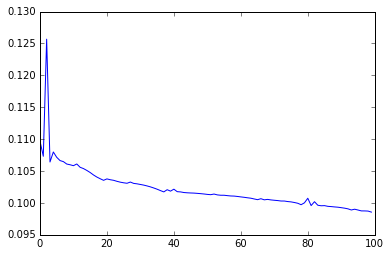

In [11]:
x=[i for i in range(len(error))]
plt.plot(x, error)
plt.show()

In [12]:
import feature_extractor
import scipy.io.wavfile as wav
import math

extractor = feature_extractor.FeatureExtractor()

def final_result(audio_signal):
    all_result = []
    for frame_feature in extractor.extract_features_per_frame(audio_signal = audio_signal):
        frame_feature = (np.asarray(frame_feature)-min_value)/(max_value-min_value)
        frame_result = int_to_lab[rnn.activate(frame_feature).argmax()]
        all_result.append(frame_result)
    label_counts = Counter(all_result)
    print label_counts
    return max(label_counts, key = label_counts.get)

In [ ]:
from os import listdir
from os.path import isfile, join
import scipy.io.wavfile as wav

path = 'tess_data'

y_pred=[]
y_actual=[]

audio_files = [f for f in listdir(path) if isfile(join(path, f))]
for audio_file in audio_files[:100]:
    y_pred.append(final_result(audio_signal = wav.read(join(path, audio_file))))
    y_actual.append(audio_file.split('_')[2].split('.')[0])

In [ ]:
import sys
sys.getsizeof(trainer)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1_score, _ = precision_recall_fscore_support(y_actual, y_pred, labels=['neutral','positive','negative'])
print "Precision = "+str(precision)+"\nRecall = "+str(recall)+"\nF1 Score = "+str(f1_score)

In [ ]:
file_name = raw_input("Enter the name of the call file name.\n> ")
rate_sig, sig = wav.read(file_name)

plt.plot(sig)
plt.plot((0,len(sig)),(0,0),'g')
plt.show()

complete_call_result = final_result(audio_signal = (rate_sig, sig))
first_half_result = final_result(audio_signal = (rate_sig, sig[:int(len(sig)/2)]))
second_half_result = final_result(audio_signal = (rate_sig, sig[int(len(sig)/2):]))
segment_result = []
for i in range(int(math.ceil(len(sig)/(rate_sig*20)))):
    segment_result.append(final_result(audio_signal = (rate_sig, sig[i*rate_sig*20:i*rate_sig*20+rate_sig*20])))

In [ ]:
import numpy as np
from __future__ import division
print "Overall call result: "+complete_call_result
print "Trainsition: "+first_half_result+" --> "+second_half_result
map_dict = {'negative':-1, 'neutral':0, 'positive':1}
mapped_segment_result = [map_dict[result] for result in segment_result]
index = [i for i in range(len(mapped_segment_result))]
index = np.asarray(index)
bar_width = 1
plt.plot((0,index[-1]+1),((0,0)), 'r')
plt.bar(index, mapped_segment_result, bar_width)
plt.xticks(index + bar_width/2 , (str(i*20)+'-'+str((i+1)*20) for i in index))
plt.xlabel('Time series with 20 seconds chunk')
#plt.axes([0, 100, -2, 2])
plt.ylabel('Emotion:\n1 = positive\n0 = neutral\n-1 = negative')
plt.title('Emotion per 20 second segment')
plt.show()

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(cm))
    plt.xticks(tick_marks, ['neutral','positive','negative'], rotation=45)
    plt.yticks(tick_marks, ['neutral','positive','negative'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_actual, y_pred, labels=['neutral','positive','negative'])
print cm
plot_confusion_matrix(cm)

In [ ]:
len([1 for i in range(len(y_pred)) if y_pred[i]==y_actual[i]])/float(len(y_pred))

In [ ]:
lab[1] 